# Bias variance demostration

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [352]:
# function
from pyspark.ml import regression, evaluation, feature, tuning, Pipeline
from pyspark.sql import functions as fn
import pandas as pd
import numpy as np

In [84]:
import matplotlib.pyplot as plt

In [369]:
# define dataset with x, true f(x), and observation f(x) + epsilon
f_x = (5*fn.pow(fn.lit(1000), -fn.col('x'))).alias('f_x')
data_df = (spark
 .range(0, 1000, )
 .select((fn.col('id')/1000).alias('x'))
 .select('x', 
         f_x,
        (f_x + fn.randn()*0.3).alias('y')
        )
)

In [370]:
data_df.show()

+-----+------------------+------------------+
|    x|               f_x|                 y|
+-----+------------------+------------------+
|  0.0|               5.0| 5.817262834729405|
|0.001| 4.965580242104669| 4.658218558179751|
|0.002| 4.931397428156052| 5.093044582231613|
|0.003| 4.897449927043494| 4.585157916747835|
|0.004| 4.863736118884826|5.5474569184221565|
|0.005| 4.830254394949066| 5.255413821775708|
|0.006| 4.797003157579666| 5.007818683864551|
|0.007|  4.76398082011826|4.8490734021003865|
|0.008| 4.731185806828965| 4.688555514100653|
|0.009| 4.698616552823189|  4.50677726068507|
| 0.01| 4.666271503984955| 4.438614416292048|
|0.011| 4.634149116896746| 4.948115466308198|
|0.012| 4.602247858765857| 4.318067157463832|
|0.013| 4.570566207351251| 4.536136078065777|
|0.014|4.5391026508909285| 4.957895929491435|
|0.015| 4.507855688029784|  4.55972348099605|
|0.016| 4.476823827747969| 4.834536909780524|
|0.017| 4.446005589289742|4.5039067622302875|
|0.018| 4.415399502092814|4.402692

In [371]:
# some functionality for plotting
def plot_data(all_data, training_df=None, model=None):
    fig = plt.figure()
    ax = fig.subplots(1,1)
    all_data.toPandas().plot(x='x', y='f_x', ax=ax)
    if training_df is None:
        all_data.toPandas().plot(x='x', y='y', kind='scatter', color='r', ax=ax)
    if training_df is not None:
        training_df.toPandas().plot(x='x', y='y', kind='scatter', color='r', ax=ax)
        model.transform(all_data).orderBy('x').toPandas().\
            plot(x='x', y='prediction', color='g', ax=ax)
    return fig

def create_data(data, n):
    return (
        data_df
        .orderBy(fn.rand())
        .limit(n)
        .orderBy('x').randomSplit([0.8, 0.2], seed=0)
    )


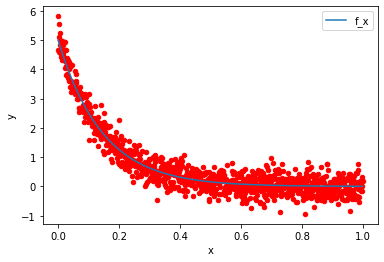

In [373]:
plot_data(data_df);

# model with polynomial regression

In [377]:
va = feature.VectorAssembler(inputCols=['x'], outputCol='features')
pe = feature.PolynomialExpansion(inputCol='features', degree=1, outputCol='features_exp')
re = regression.LinearRegression(featuresCol='features_exp', labelCol='y')
pl = Pipeline(stages=[va, pe, re])

In [378]:
pg = tuning.ParamGridBuilder()

In [379]:
grid = pg.addGrid(pe.degree, [1, 5, 10, 100, 500]).build()

In [380]:
evaluator = evaluation.RegressionEvaluator(labelCol='y')
tvs = tuning.TrainValidationSplit(estimator=pl, 
                                  estimatorParamMaps=grid,
                                  evaluator=evaluator, parallelism=3)

# small $n$

In [381]:
training_df, testing_df = create_data(data_df, 100)

In [382]:
best_model = tvs.fit(training_df)

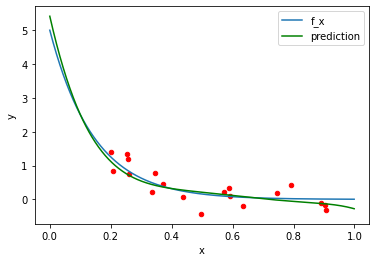

In [384]:
# best model chosen through cross validation
plot_data(data_df, testing_df, best_model);

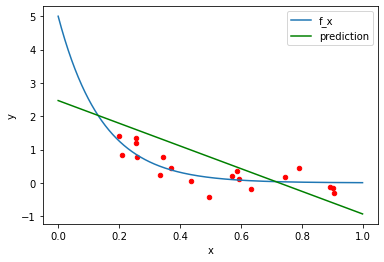

In [385]:
# simplest model
plot_data(data_df, testing_df, pl.fit(training_df, grid[0]));

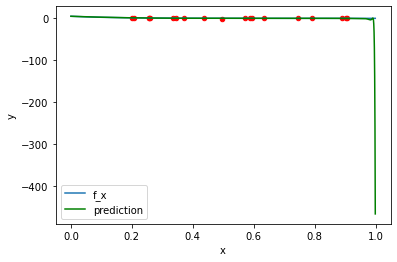

In [386]:
# most complex model
plot_data(data_df, testing_df, pl.fit(training_df, grid[4]));

In [387]:
# estimate rmse as a function of degree
performance = pd.DataFrame([
    {'p': list(g.values())[0], 
     'rmse': evaluator.evaluate(pl.fit(training_df, g).transform(testing_df))}
    for g in grid
])

In [388]:
# compute log(p)
performance['log(p)'] = np.log(performance['p'])

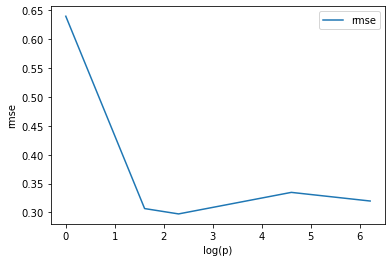

In [389]:
performance.plot(x='log(p)', y='rmse')
plt.ylabel('rmse');

# large $n$

In [390]:
training_df, testing_df = create_data(data_df, 1000)

In [391]:
best_model = tvs.fit(training_df)

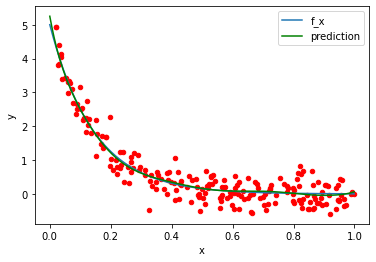

In [392]:
# best model chosen through cross validation
plot_data(data_df, testing_df, best_model);

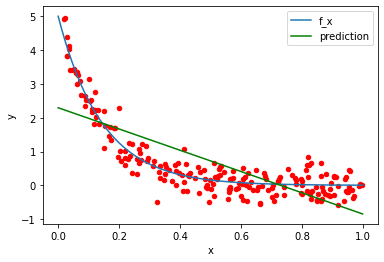

In [393]:
# simplest model
plot_data(data_df, testing_df, pl.fit(training_df, grid[0]));

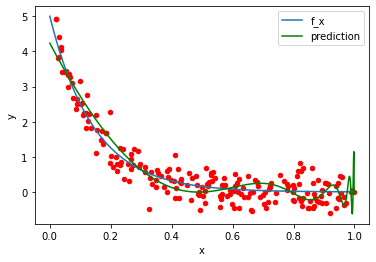

In [394]:
# most complex model
plot_data(data_df, testing_df, pl.fit(training_df, grid[4]));

In [395]:
# estimate rmse as a function of degree
performance = pd.DataFrame([
    {'p': list(g.values())[0], 
     'rmse': evaluator.evaluate(pl.fit(training_df, g).transform(testing_df))}
    for g in grid
])

In [396]:
# compute log(p)
performance['log(p)'] = np.log(performance['p'])

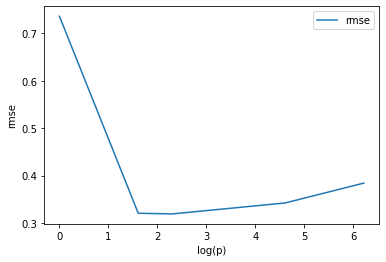

In [397]:
performance.plot(x='log(p)', y='rmse')
plt.ylabel('rmse');